In [2]:
# Import libraries

import pandas as pd
import numpy as np
import random as rnd
import sklearn as skl
import seaborn as sn
import matplotlib.pyplot as plt
import sympy as sp
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
import warnings
from IPython.display import display, Math
from pickle import dump

warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [3]:
# Import data
dfDiabetesClass_raw = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=421&path=diabetes.csv")

In [4]:
# Data inspection

print(dfDiabetesClass_raw.shape)
print(dfDiabetesClass_raw.info())

# Verify duplicates and NANs

if dfDiabetesClass_raw.duplicated().any().any():
    dfDiabetesClass_raw = dfDiabetesClass_raw.drop_duplicates()

if dfDiabetesClass_raw.isna().any().any():
    dfDiabetesClass_raw = dfDiabetesClass_raw.dropna()

(768, 9)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [5]:
dfDiabetesClass_raw['Outcome'].value_counts()


Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
"""
indices0 = dfDiabetesClass_raw.index[dfDiabetesClass_raw['Outcome'] == 0].tolist()
indices1 = dfDiabetesClass_raw.index[dfDiabetesClass_raw['Outcome'] == 1].tolist()

n = 300 # Number of elements to pick

# Select 4 unique random numbers
indices0_unique = rnd.sample(indices0, n)
indices_total = np.concatenate((indices0_unique, indices1))
indices_total.sort()
dfDiabetesClass_new = dfDiabetesClass_raw.iloc[indices_total].copy()
dfDiabetesClass_new['Outcome'].value_counts()
"""


"\nindices0 = dfDiabetesClass_raw.index[dfDiabetesClass_raw['Outcome'] == 0].tolist()\nindices1 = dfDiabetesClass_raw.index[dfDiabetesClass_raw['Outcome'] == 1].tolist()\n\nn = 300 # Number of elements to pick\n\n# Select 4 unique random numbers\nindices0_unique = rnd.sample(indices0, n)\nindices_total = np.concatenate((indices0_unique, indices1))\nindices_total.sort()\ndfDiabetesClass_new = dfDiabetesClass_raw.iloc[indices_total].copy()\ndfDiabetesClass_new['Outcome'].value_counts()\n"

In [7]:
#dfDiabetesClass_raw = dfDiabetesClass_new

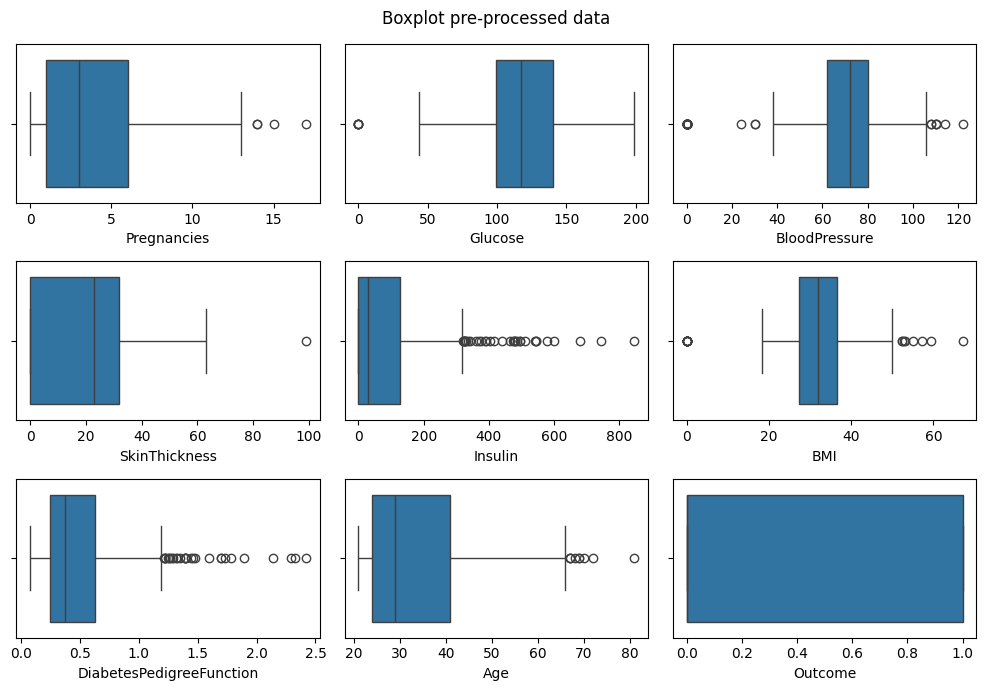

In [8]:
# Exploratory data analysis

# Get outliers
fig, axis = plt.subplots(3,3,figsize=(10,7))
r = 0
c = 0
for col_name in dfDiabetesClass_raw.columns:
    sn.boxplot(ax=axis[r,c], data = dfDiabetesClass_raw, x = dfDiabetesClass_raw[col_name])
    c += 1
    if c > 2:
        r += 1
        c = 0

plt.suptitle('Boxplot pre-processed data')
plt.tight_layout()
plt.show()

   

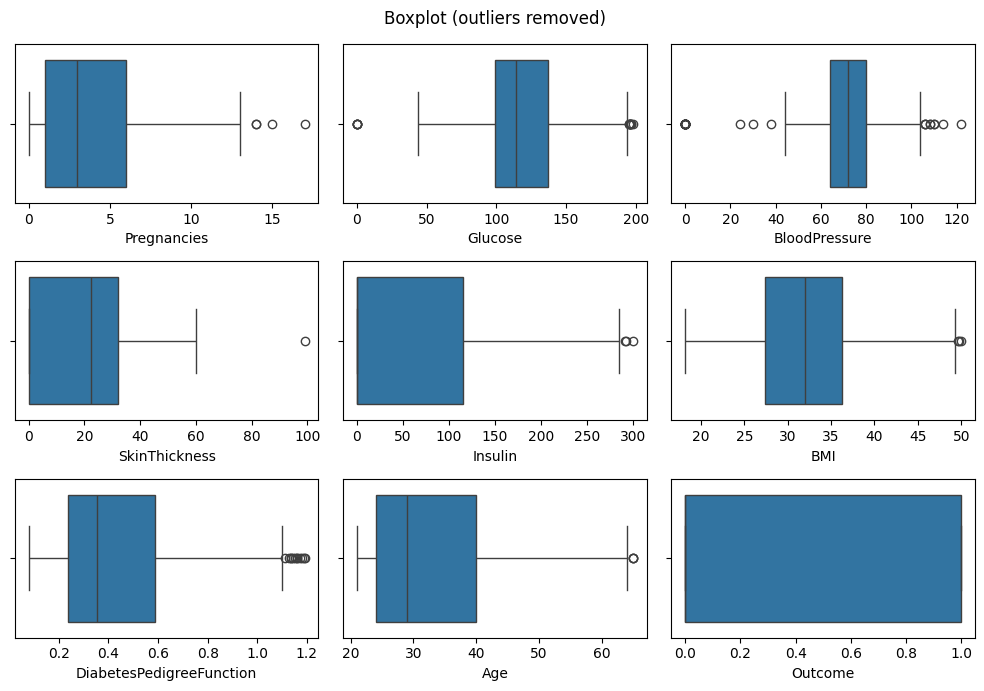

In [9]:
# Remove some of the outliers

dfDiabetesClass_processed = dfDiabetesClass_raw
dfDiabetesClass_processed = dfDiabetesClass_processed[dfDiabetesClass_processed['Insulin'] <= 300]
dfDiabetesClass_processed = dfDiabetesClass_processed[dfDiabetesClass_processed['DiabetesPedigreeFunction'] <= 1.2]
dfDiabetesClass_processed = dfDiabetesClass_processed[dfDiabetesClass_processed['Age'] <= 65]
dfDiabetesClass_processed = dfDiabetesClass_processed[dfDiabetesClass_processed['BMI'] <= 50]
dfDiabetesClass_processed = dfDiabetesClass_processed[dfDiabetesClass_processed['BMI'] >= 18]

fig, axis = plt.subplots(3,3,figsize=(10,7))
r = 0
c = 0
for col_name in dfDiabetesClass_raw.columns:
    sn.boxplot(ax=axis[r,c], data = dfDiabetesClass_processed, x = dfDiabetesClass_processed[col_name])
    c += 1
    if c > 2:
        r += 1
        c = 0

plt.suptitle('Boxplot (outliers removed)')
plt.tight_layout() 
plt.show()  

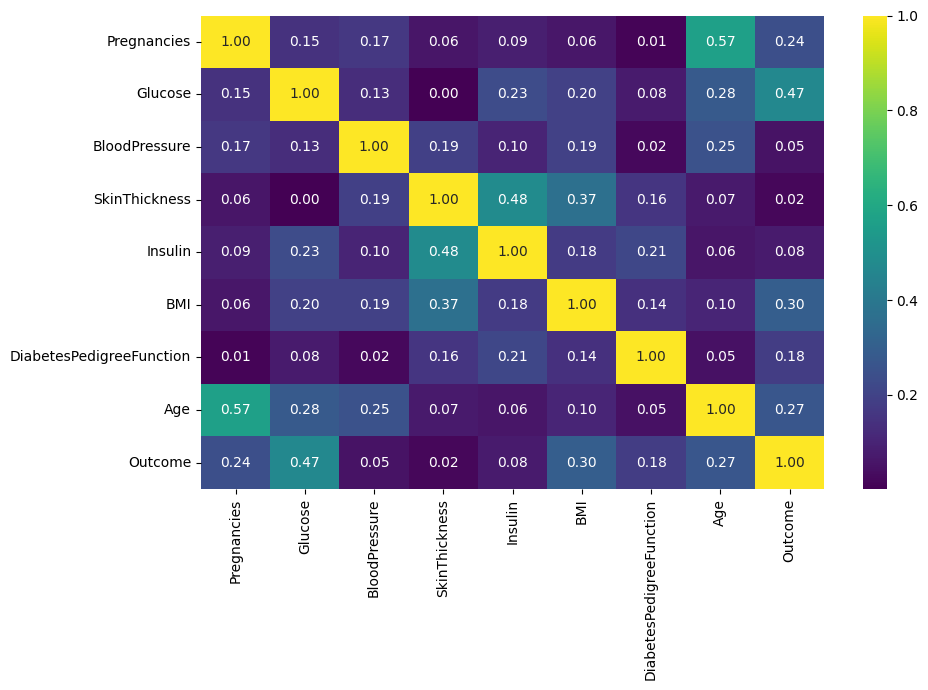

In [10]:
# Get correlation matrix

fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(dfDiabetesClass_processed.corr(method="pearson").abs(), annot=True, annot_kws={"fontsize": 10}, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

In [11]:
# Get features based on correlation matrix (threshold > 0.2)
correlationMatrix     = dfDiabetesClass_processed.corr(method='pearson',numeric_only=True)
correlationMatrix_abs = correlationMatrix['Outcome'].abs()
feature_names         = correlationMatrix_abs.index[correlationMatrix_abs > 0.2].to_list()

print(f'The independent variables that explain the variable "Outcome" are: {feature_names[:-1]}')


The independent variables that explain the variable "Outcome" are: ['Pregnancies', 'Glucose', 'BMI', 'Age']


             Pregnancies  Glucose   BMI   Age
Pregnancies        1.000    0.146 0.064 0.567
Glucose            0.146    1.000 0.195 0.279
BMI                0.064    0.195 1.000 0.105
Age                0.567    0.279 0.105 1.000


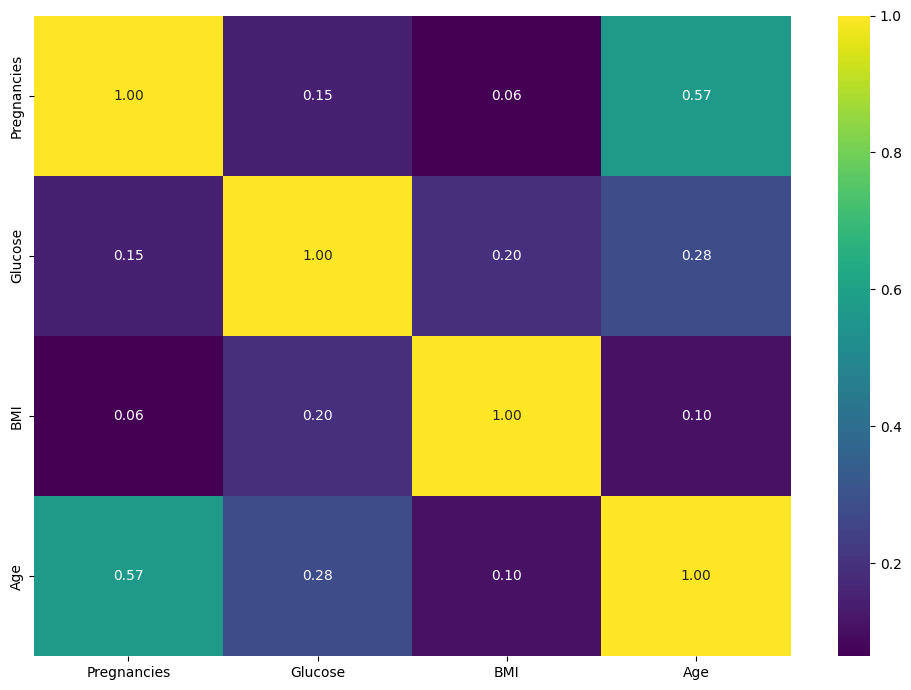

Age and pregnancies have a correlation of 0.531, which is larger than the threshold of 0.5.


In [12]:
# Verify that features do not have high correlation

dfDiabetesClass_processed_featured = dfDiabetesClass_processed[feature_names]
dfDiabetesClass_processed_featured = dfDiabetesClass_processed_featured.drop(columns=['Outcome'])
feature_correlation = dfDiabetesClass_processed_featured.corr(method="pearson")
print(feature_correlation)

fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(dfDiabetesClass_processed_featured.corr(method="pearson").abs(), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

print("Age and pregnancies have a correlation of 0.531, which is larger than the threshold of 0.5.")

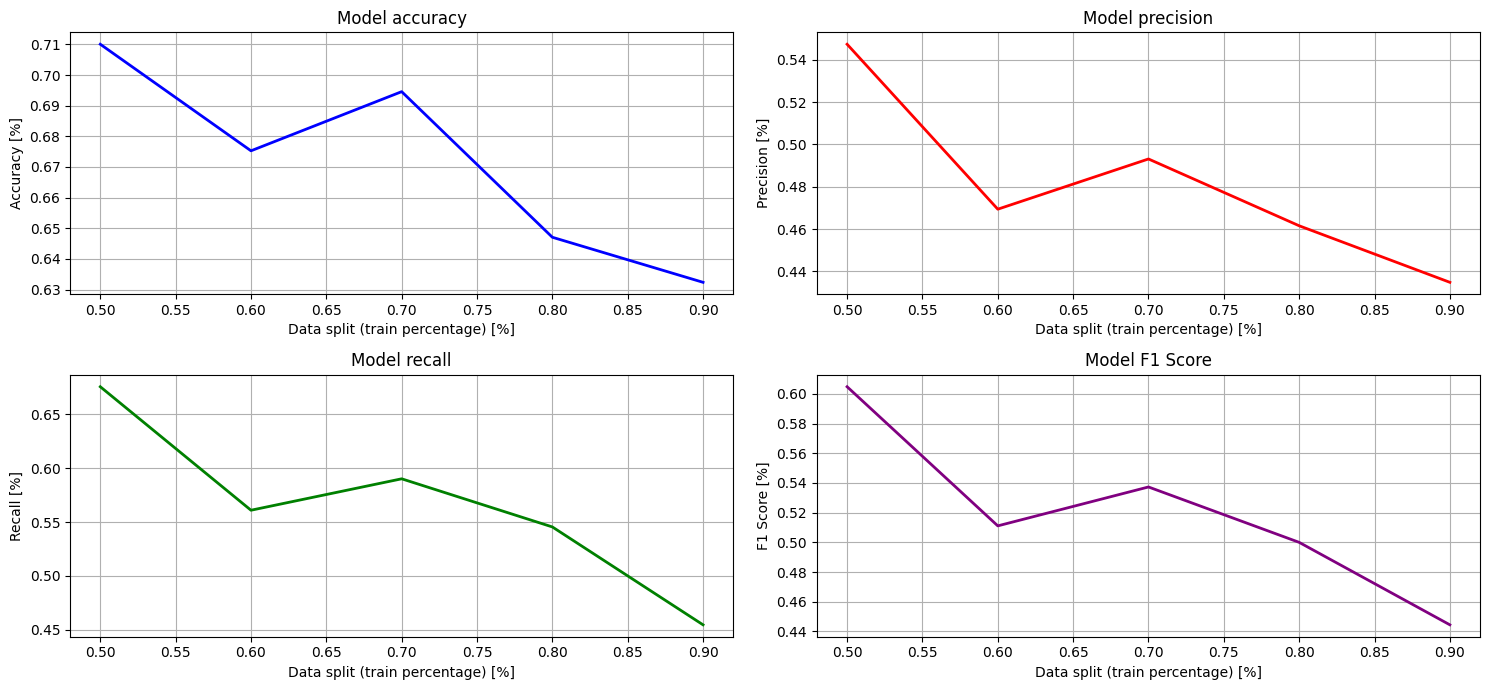

In [13]:
# # Exclusion of independent variables based on the feature correlation matrix
features      = feature_names[1:]  # Exclude 'Pregnancies' due to high correlation with 'Age'
features      = feature_names[:-1]  # Exclude target variable

target   = 'Outcome'

# Set up the data

X      = dfDiabetesClass_processed[features]
y      = dfDiabetesClass_processed[target]

# To test best split trade-off we loop over different splitting ratios

accuracy  = []
precision = []
recall    = []
f1        = []


for split_ratio in np.arange(0.5,1,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = split_ratio)

    # Decision Tree Classifier

    diabetes_model = DecisionTreeClassifier() 
    diabetes_model.fit(X_train, y_train)

    # Perform prediction
    y_pred = diabetes_model.predict(X_test)

    # Compute accuracy, precision, and recall
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))

# Plot split vs. scores

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(15,7))

ax0.plot(np.arange(0.5,1,0.1),accuracy,color='blue',linewidth=2)
ax0.grid()
ax0.set_xlabel("Data split (train percentage) [%]")
ax0.set_ylabel("Accuracy [%]")
ax0.set_title("Model accuracy")
ax1.plot(np.arange(0.5,1,0.1),precision,color='red',linewidth=2)
ax1.grid()
ax1.set_xlabel("Data split (train percentage) [%]")
ax1.set_ylabel("Precision [%]")
ax1.set_title("Model precision")
ax2.plot(np.arange(0.5,1,0.1),recall,color='green',linewidth=2)
ax2.grid()
ax2.set_xlabel("Data split (train percentage) [%]")
ax2.set_ylabel("Recall [%]")
ax2.set_title("Model recall")
ax3.plot(np.arange(0.5,1,0.1),f1,color='purple',linewidth=2)
ax3.grid()
ax3.set_xlabel("Data split (train percentage) [%]")
ax3.set_ylabel("F1 Score [%]")
ax3.set_title("Model F1 Score")

plt.tight_layout()

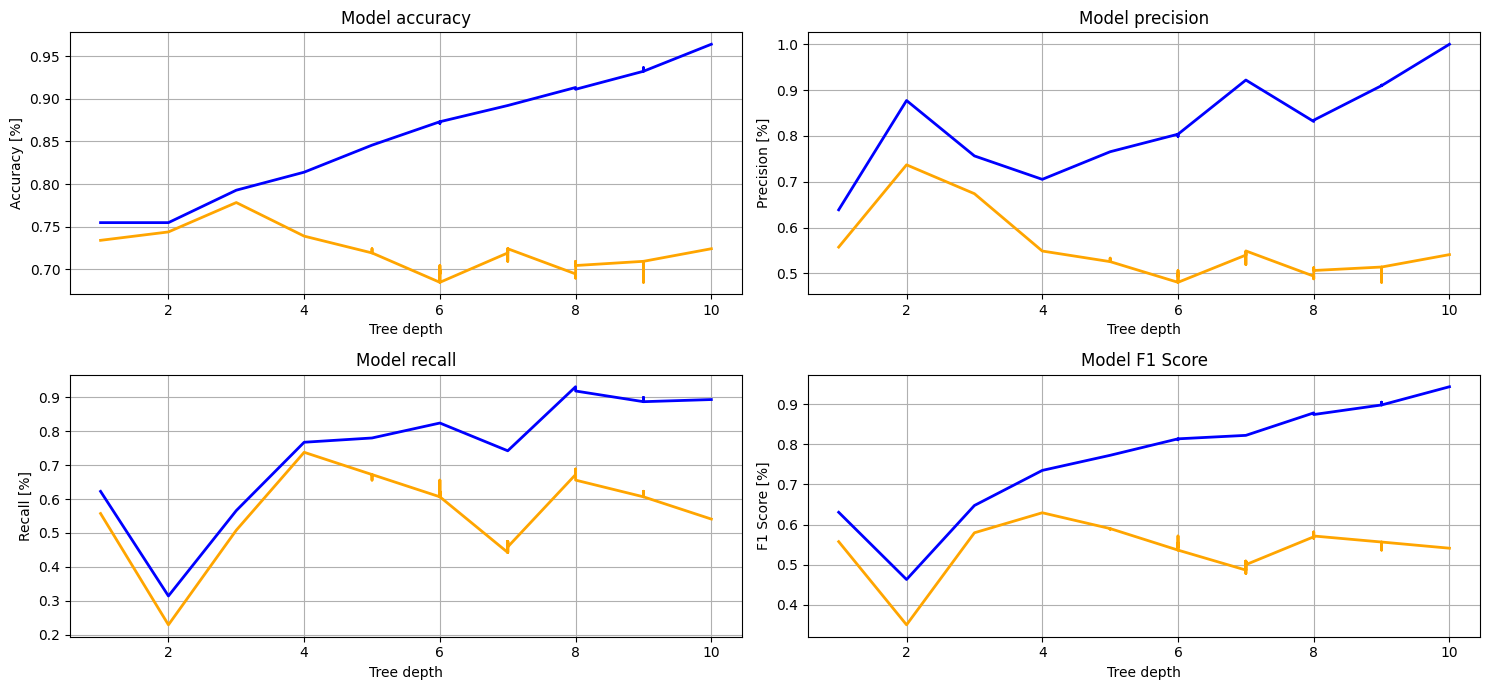

In [14]:
# To test best tree max depth, we loop over different tree depths

best_split = 0.7  # From previous analysis

accuracy_train  = []
accuracy_test   = []
precision_train = []
precision_test  = []
recall_train    = []
recall_test     = []
f1_train        = []
f1_test         = []

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = best_split)

tree_depth_line = np.linspace(1,10).astype(int)

for tree_depth in tree_depth_line:
    # Decision tree classifier

    diabetes_model = DecisionTreeClassifier(max_depth=tree_depth)
    diabetes_model.fit(X_train, y_train)

    # Perform prediction
    y_pred_train = diabetes_model.predict(X_train)
    y_pred_test = diabetes_model.predict(X_test)

    # Compute accuracy, precision, and recall
    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    precision_train.append(precision_score(y_train, y_pred_train))
    precision_test.append(precision_score(y_test, y_pred_test))
    recall_train.append(recall_score(y_train, y_pred_train))
    recall_test.append(recall_score(y_test, y_pred_test))
    f1_train.append(f1_score(y_train, y_pred_train))
    f1_test.append(f1_score(y_test, y_pred_test))

# Plot split vs. scores

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(15,7))

ax0.plot(tree_depth_line,accuracy_train,color='blue',linewidth=2)
ax0.plot(tree_depth_line,accuracy_test,color='orange',linewidth=2)
ax0.grid()
ax0.set_xlabel("Tree depth")
ax0.set_ylabel("Accuracy [%]")
ax0.set_title("Model accuracy")
ax1.plot(tree_depth_line,precision_train,color='blue',linewidth=2)
ax1.plot(tree_depth_line,precision_test,color='orange',linewidth=2)
ax1.grid()
ax1.set_xlabel("Tree depth")
ax1.set_ylabel("Precision [%]")
ax1.set_title("Model precision")
ax2.plot(tree_depth_line,recall_train,color='blue',linewidth=2)
ax2.plot(tree_depth_line,recall_test,color='orange',linewidth=2)
ax2.grid()
ax2.set_xlabel("Tree depth")
ax2.set_ylabel("Recall [%]")
ax2.set_title("Model recall")
ax3.plot(tree_depth_line,f1_train,color='blue',linewidth=2)
ax3.plot(tree_depth_line,f1_test,color='orange',linewidth=2)
ax3.grid()
ax3.set_xlabel("Tree depth")
ax3.set_ylabel("F1 Score [%]")
ax3.set_title("Model F1 Score")

plt.tight_layout()

In [15]:
# Choosing best split ratio = 60%

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = best_split)

# Tree classification

best_tree_depth = 3  # From previous analysis

diabetes_model = DecisionTreeClassifier(max_depth=best_tree_depth)
diabetes_model.fit(X_train, y_train)

# Perform prediction
y_pred = diabetes_model.predict(X_test)

# Compute accuracy, precision, recall, and f1 score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'The accuracy score of the model is: {accuracy}\n')
print(f'The precision score of the model is: {precision}\n')
print(f'The recall score of the model is: {recall}\n')
print(f'The F1 score of the model is: {f1}')

The accuracy score of the model is: 0.7783251231527094

The precision score of the model is: 0.6739130434782609

The recall score of the model is: 0.5081967213114754

The F1 score of the model is: 0.5794392523364486


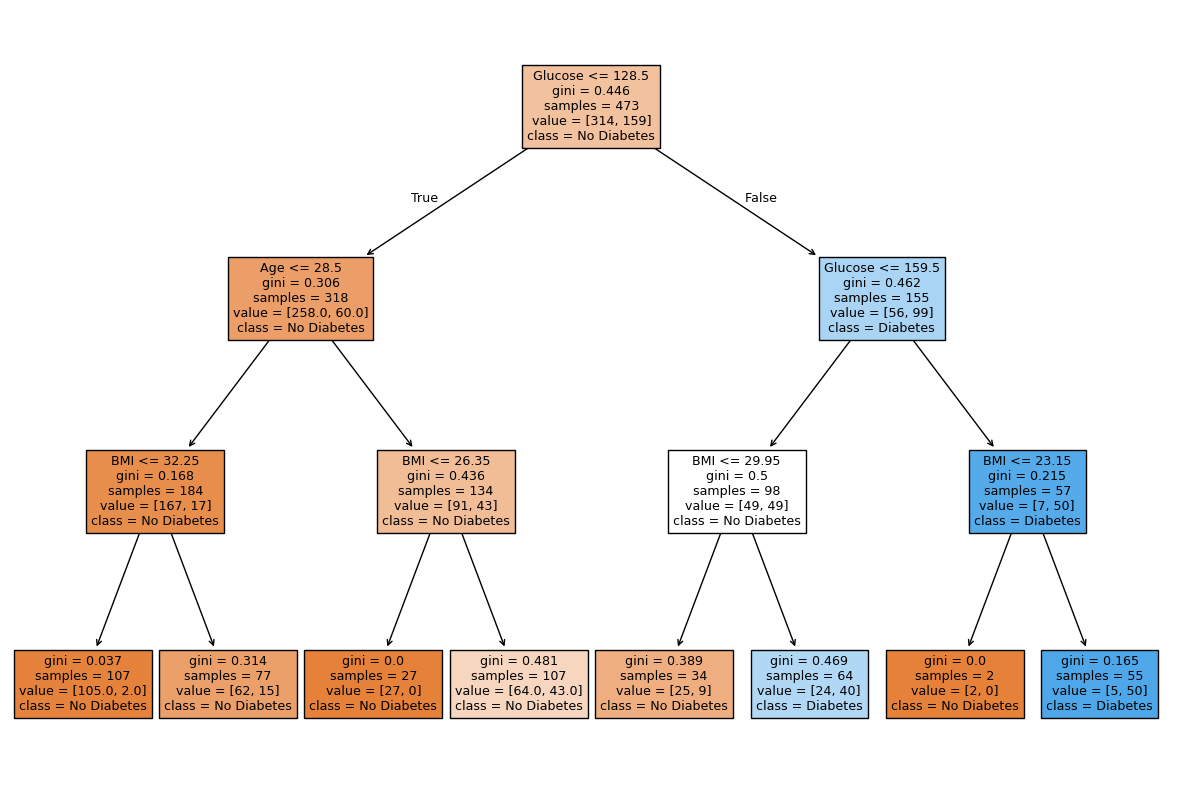

In [16]:
fig = plt.figure(figsize=(15,10))
plot_tree(diabetes_model, feature_names=features, class_names=['No Diabetes','Diabetes'], filled=True)
plt.show()

In [17]:
# Hyperparameter optimization

hyperparams = {
    "max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    
}

# We initialize the grid
grid = GridSearchCV(diabetes_model, hyperparams, scoring = 'accuracy', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

diabetes_model = DecisionTreeClassifier(**grid.best_params_)
diabetes_model.fit(X_train, y_train)
y_pred = diabetes_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy   = accuracy_score(y_test, y_pred)
grid_precision  = precision_score(y_test, y_pred)
grid_recall     = recall_score(y_test, y_pred)
grid_f1         = f1_score(y_test, y_pred)

print('The classification model to predict the diabetes uses the following independent variables\n')
for i, col in enumerate(features):
    print(f'{i+1}. {col}')
print('\n')

print(f'The classification after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy:0.3f}')
print(f'Precision = {grid_precision:0.3f}')
print(f'Recall = {grid_recall:0.3f}')
print(f'F1 Score = {grid_f1:0.3f}\n')

Best hyperparameters: {'max_depth': 5}
The classification model to predict the diabetes uses the following independent variables

1. Pregnancies
2. Glucose
3. BMI
4. Age


The classification after processing the data has the following performance parameters:

Accuracy = 0.719
Precision = 0.526
Recall = 0.672
F1 Score = 0.590



The model prediction capability is rather limited due to the fact that features used to predict the diabetes outcome do not have a strong correlation with the target variable. The fact that the precision of the model is lower than the recall indicates that the model is better at identifying true positives (diabetic patients) than avoiding false positives (non-diabetic patients classified as diabetic). This is confirmed by the F1 score being closer to the recall than to the precision.

More relevant features are required to improve the model performance.

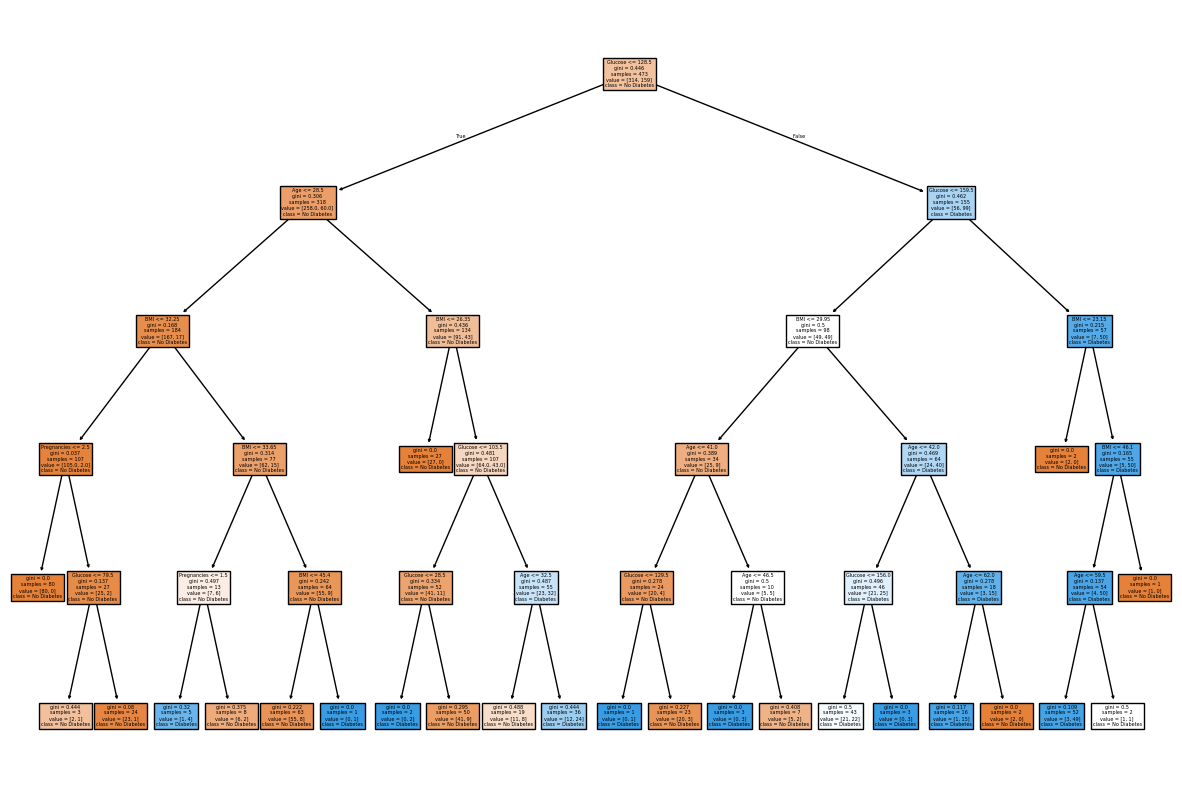

In [18]:
fig = plt.figure(figsize=(15,10))
plot_tree(diabetes_model, feature_names=features, class_names=['No Diabetes','Diabetes'], filled=True)
plt.show()

In [19]:
## Save the model
dump(diabetes_model, open("decision_tree_classifier_default_42.sav", "wb"))

In [20]:
## Improve model with random forest classifier

optim_best_depth = grid.best_params_['max_depth']

diabetes_model = RandomForestClassifier(max_depth=optim_best_depth, random_state=42)
diabetes_model.fit(X_train, y_train)

# Perform prediction
y_pred = diabetes_model.predict(X_test)

# Compute accuracy, precision, recall, and f1 score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'The accuracy score of the model is: {accuracy:0.3f}\n')
print(f'The precision score of the model is: {precision:0.3f}\n')
print(f'The recall score of the model is: {recall:0.3f}\n')
print(f'The F1 score of the model is: {f1:0.3f}')

The accuracy score of the model is: 0.764

The precision score of the model is: 0.614

The recall score of the model is: 0.574

The F1 score of the model is: 0.593


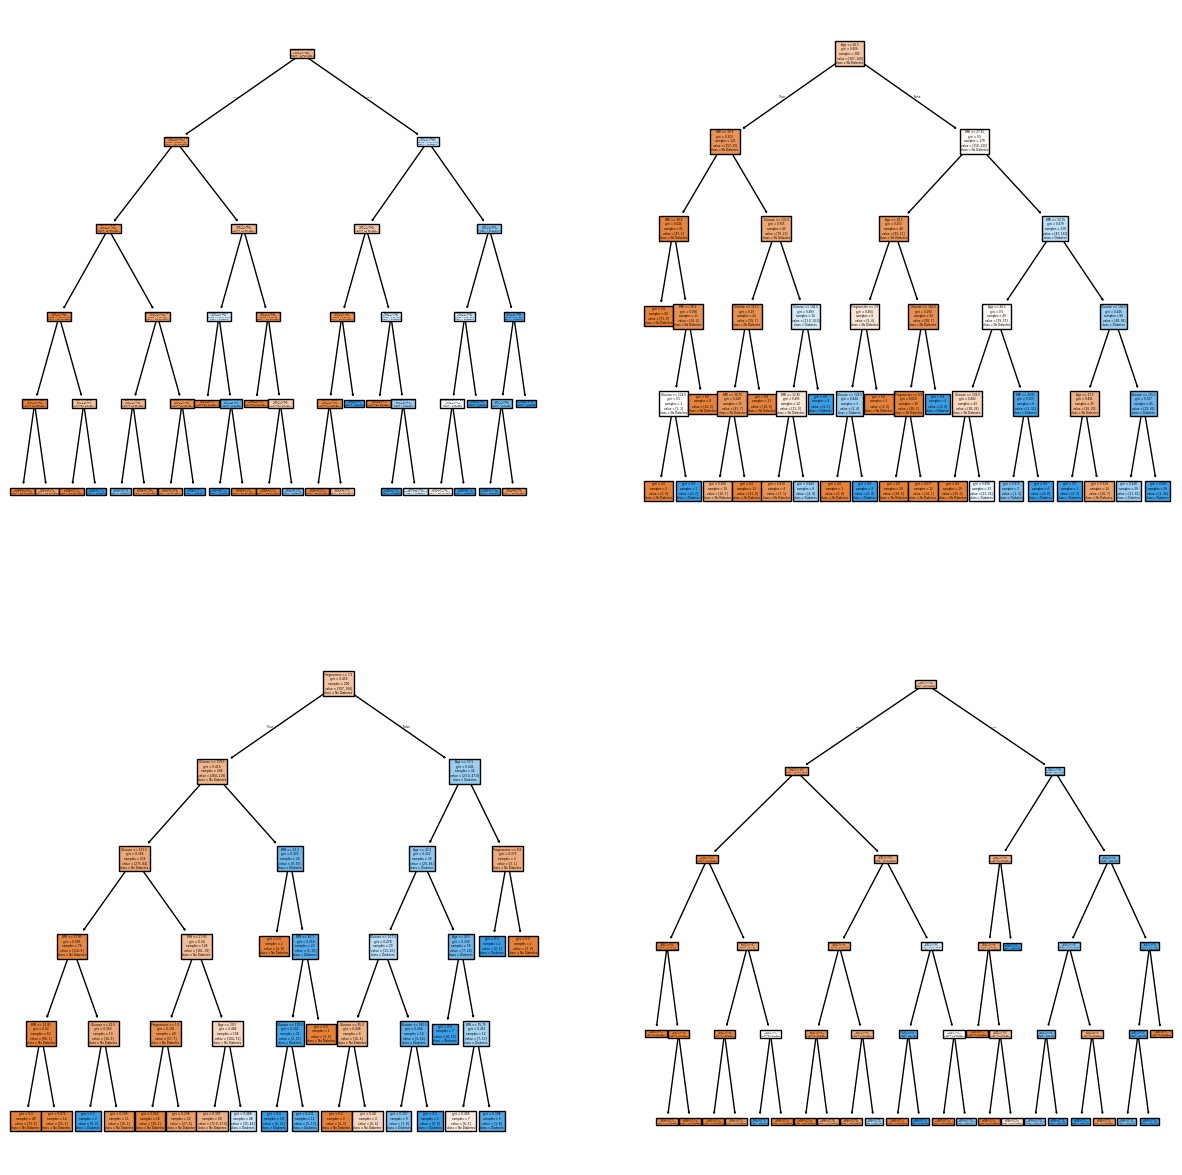

In [21]:
fig, axis = plt.subplots(2,2,figsize=(15,15))
plot_tree(diabetes_model.estimators_[0], feature_names=features, class_names=['No Diabetes','Diabetes'], filled=True, ax = axis[0, 0])
plot_tree(diabetes_model.estimators_[1], feature_names=features, class_names=['No Diabetes','Diabetes'], filled=True, ax = axis[0, 1])
plot_tree(diabetes_model.estimators_[2], feature_names=features, class_names=['No Diabetes','Diabetes'], filled=True, ax = axis[1, 0])
plot_tree(diabetes_model.estimators_[3], feature_names=features, class_names=['No Diabetes','Diabetes'], filled=True, ax = axis[1, 1])
plt.show()

In [22]:
# Hyperparameter optimization

hyperparams = {
    "max_depth": [None, 2, 4, 6, 8, 10],
    "n_estimators": [100, 200, 300, 500]
    
}

# We initialize the grid
grid = GridSearchCV(diabetes_model, hyperparams, scoring = 'accuracy', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

diabetes_model = RandomForestClassifier(**grid.best_params_)
diabetes_model.fit(X_train, y_train)
y_pred = diabetes_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy   = accuracy_score(y_test, y_pred)
grid_precision  = precision_score(y_test, y_pred)
grid_recall     = recall_score(y_test, y_pred)
grid_f1         = f1_score(y_test, y_pred)

print('The classification model to predict the diabetes uses the following independent variables\n')
for i, col in enumerate(features):
    print(f'{i+1}. {col}')
print('\n')

print(f'The classification after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy:0.3f}')
print(f'Precision = {grid_precision:0.3f}')
print(f'Recall = {grid_recall:0.3f}')
print(f'F1 Score = {grid_f1:0.3f}\n')

Best hyperparameters: {'max_depth': 6, 'n_estimators': 500}
The classification model to predict the diabetes uses the following independent variables

1. Pregnancies
2. Glucose
3. BMI
4. Age


The classification after processing the data has the following performance parameters:

Accuracy = 0.773
Precision = 0.615
Recall = 0.656
F1 Score = 0.635



The random forest algorithm achieves a better performance across the board with respect to each metric compared to the simple decision tree algorithm. Although the parameters are below 80%, the metrics of precision, recall, and F1 score are closer together at around 63%. This suggests that the model is now as good predicting true positives (recall) and avoiding false positives (precision), rather than having the skewed performance exhibited by the simple decision tree model.

In [23]:
## Save the model
dump(diabetes_model, open("random_forest_classifier_default_42.sav", "wb"))

In [24]:
## Improve model with extreme gradient booster

diabetes_model = XGBClassifier(random_state=42)
diabetes_model.fit(X_train, y_train)

# Perform prediction
y_pred = diabetes_model.predict(X_test)

# Compute accuracy, precision, recall, and f1 score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'The accuracy score of the model is: {accuracy:0.3f}\n')
print(f'The precision score of the model is: {precision:0.3f}\n')
print(f'The recall score of the model is: {recall:0.3f}\n')
print(f'The F1 score of the model is: {f1:0.3f}')

The accuracy score of the model is: 0.724

The precision score of the model is: 0.535

The recall score of the model is: 0.623

The F1 score of the model is: 0.576


In [25]:
# Hyperparameter optimization

hyperparams = {
    "n_estimators": [5, 10, 20, 50],
    "max_depth": [None, 5, 10, 20],
    "eta": [0.1, 0.3, 0.5, 0.8],
    "gamma": [1, 5, 10, 20, 50]
    
}

# We initialize the grid
grid = GridSearchCV(diabetes_model, hyperparams, scoring = 'accuracy', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

diabetes_model = XGBClassifier(**grid.best_params_)
diabetes_model.fit(X_train, y_train)
y_pred = diabetes_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy   = accuracy_score(y_test, y_pred)
grid_precision  = precision_score(y_test, y_pred)
grid_recall     = recall_score(y_test, y_pred)
grid_f1         = f1_score(y_test, y_pred)

print('The classification model to predict the diabetes uses the following independent variables\n')
for i, col in enumerate(features):
    print(f'{i+1}. {col}')
print('\n')

print(f'The classification after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy:0.3f}')
print(f'Precision = {grid_precision:0.3f}')
print(f'Recall = {grid_recall:0.3f}')
print(f'F1 Score = {grid_f1:0.3f}\n')

Best hyperparameters: {'eta': 0.3, 'gamma': 20, 'max_depth': None, 'n_estimators': 5}
The classification model to predict the diabetes uses the following independent variables

1. Pregnancies
2. Glucose
3. BMI
4. Age


The classification after processing the data has the following performance parameters:

Accuracy = 0.764
Precision = 0.676
Recall = 0.410
F1 Score = 0.510



The best models in terms of accuracy are random forest and gradient boost with comparable accuracy at ~76 %. However, the random forest shows a more balanced performance in terms of precision and recall, with the highest F1 score across the board. This means that the random forest model is as good discerning false positives and false negatives altogether. Conversely, the gradient boost has a much higher precision, meaning that it can discern true positives from false positives to the detriment of an extremely low recall, thereby, having a worse performance at detecting false negatives (people diagnosed as healthy but with actual diabetes). This can be also seen in the rather low F1 score of the gradient bost model.

The decision tree, has an acceptable performance too, having a lower accuracy in general, and the opposite behavior of the gradient boost: lower precision, higher recall, i.e., better at detecting false negatives, but worse at detecting false positives.

In general, the best attained model is random forest.

| Metric| Decision Tree | Random Forest | Gradient boost |
|---|:---:|:---:|:---:|
Accuracy | 0.719 | 0.768 | 0.764 |
Precision | 0.526 | 0.609 | 0.676 |
Recall | 0.672 | 0.639 | 0.410 |
F1 Score | 0.590 | 0.624 | 0.510 |

In [26]:
## Save the model
dump(diabetes_model, open("xg_boost_classifier_default_42.sav", "wb"))